In [1]:
import numpy as np
import argparse
import time
import cv2
import os
import sys
sys.path.append('..')
from opencv_course import ImageUtil

In [2]:
img='phone2.jpg'
yolo='../../yolo'
confidence=0.5
threshold=0.3

In [3]:
# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([yolo, "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

In [4]:
# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([yolo, "yolov3.weights"])
configPath = os.path.sep.join([yolo, "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

[INFO] loading YOLO from disk...


In [7]:
# load our input image and grab its spatial dimensions
image = cv2.imread(img)
w,h,x = image.shape
print(w, h, x)
cv2.resize(image, (0,0), fx=300/w, fy=300/w) 
(H, W) = image.shape[:2]
 
# determine only the *output* layer names that we need from YOLO
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]
 
# construct a blob from the input image and then perform a forward
# pass of the YOLO object detector, giving us our bounding boxes and
# associated probabilities
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
net.setInput(blob)
start = time.time()
layerOutputs = net.forward(ln)
end = time.time()
 
# show timing information on YOLO
print("[INFO] YOLO took {:.6f} seconds".format(end - start))

3024 4032 3
[INFO] YOLO took 1.498055 seconds


In [8]:
# initialize our lists of detected bounding boxes, confidences, and
# class IDs, respectively
boxes = []
confidences = []
classIDs = []

In [9]:
# loop over each of the layer outputs
for output in layerOutputs:
    # loop over each of the detections
    for detection in output:
        # extract the class ID and confidence (i.e., probability) of
        # the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        _confidence = scores[classID]

        # filter out weak predictions by ensuring the detected
        # probability is greater than the minimum probability
        if _confidence > confidence:
            # scale the bounding box coordinates back relative to the
            # size of the image, keeping in mind that YOLO actually
            # returns the center (x, y)-coordinates of the bounding
            # box followed by the boxes' width and height
            box = detection[0:4] * np.array([W, H, W, H])
            (centerX, centerY, width, height) = box.astype("int")

            # use the center (x, y)-coordinates to derive the top and
            # and left corner of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            # update our list of bounding box coordinates, confidences,
            # and class IDs
            boxes.append([x, y, int(width), int(height)])
            confidences.append(float(_confidence))
            classIDs.append(classID)

In [10]:
# apply non-maxima suppression to suppress weak, overlapping bounding
# boxes
idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence, threshold)

print(idxs)

[[0]
 [1]
 [2]]


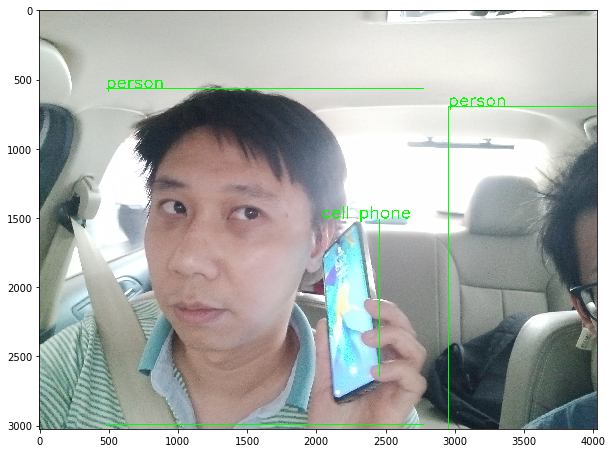

In [11]:
# ensure at least one detection exists
if len(idxs) > 0:
    # loop over the indexes we are keeping
    for i in idxs.flatten():
        # extract the bounding box coordinates
        (x, y) = (boxes[i][0], boxes[i][1])
        (w, h) = (boxes[i][2], boxes[i][3])

        # draw a bounding box rectangle and label on the image
        color = (0,255,0)
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}".format(LABELS[classIDs[i]])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 4, color, 7)

ImageUtil.imshow([image])